In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
dataset_names = sns.get_dataset_names()

In [4]:
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

In [5]:
df = sns.load_dataset('titanic')
df

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


1. 데이터 전처리
    * Feature Selection

In [6]:
df = df[['survived', 'pclass', 'sex', 'age','sibsp', 'parch','fare', 'embarked', 'deck']]
df.head(3)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,deck
0,0,3,male,22.0,1,0,7.2500,S,NaN
1,1,1,female,38.0,1,0,71.2833,C,C
2,1,3,female,26.0,0,0,7.9250,S,NaN


In [7]:
df.shape

(891, 9)

* 결측치 처리

In [8]:
df.isna().sum()

survived      0
pclass        0
sex           0
age         177
sibsp         0
parch         0
fare          0
embarked      2
deck        688
dtype: int64

In [9]:
# age
df.age.fillna(df.age.mean(), inplace=True)
# deck 결측 - drop
df.drop(columns=['deck'], inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [10]:
# embarked - 최빈값
# 최빈값
print(df.embarked.value_counts())

S    644
C    168
Q     77
Name: embarked, dtype: int64


In [11]:
df.embarked.fillna('Q', inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [12]:
# 결측치 확인
df.isna().sum().sum()

0

In [13]:
# 카테고리 값
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df.sex = le.fit_transform(df.sex)
df.embarked = le.fit_transform(df.embarked)
df.head(3)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,survived,pclass,sex,age,sibsp,parch,fare,embarked
0,0,3,1,22.0,1,0,7.2500,2
1,1,1,0,38.0,1,0,71.2833,0
2,1,3,0,26.0,0,0,7.9250,2


In [14]:
# X data : scaling
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(df.iloc[:,1:].values)

2. 학습/테스트 데이터셋 분리

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, df.iloc[:,0].values, stratify=df.iloc[:,0].values, test_size=0.2, random_state=seed
)

In [16]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((712, 7), (179, 7), (712,), (179,))

3. 모델 정의/설정

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [18]:
model = Sequential([
    Dense(30, input_dim=7, activation='relu'),
    Dense(12, activation='relu'),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                240       
                                                                 
 dense_1 (Dense)             (None, 12)                372       
                                                                 
 dense_2 (Dense)             (None, 8)                 104       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 725
Trainable params: 725
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

* 모델 저장 관련 설정

In [20]:
import os
if not os.path.exists('model'):
    os.mkdir('model')

In [21]:
model_path = 'model/titanic.h5'

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(
    model_path, monitor='val_loss', verbose=1, save_best_only=True
)

* 조기 중단 관련 설정

In [23]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience=20)

## 4. 모델 학습/저장

In [24]:
hist = model.fit(X_train, y_train, validation_split=0.2, verbose=0,
                 epochs=200, batch_size=200, 
                 callbacks=[checkpoint, early_stopping])


Epoch 00001: val_loss improved from inf to 0.79185, saving model to model/titanic.h5

Epoch 00002: val_loss improved from 0.79185 to 0.76247, saving model to model/titanic.h5

Epoch 00003: val_loss improved from 0.76247 to 0.73687, saving model to model/titanic.h5

Epoch 00004: val_loss improved from 0.73687 to 0.71500, saving model to model/titanic.h5

Epoch 00005: val_loss improved from 0.71500 to 0.69595, saving model to model/titanic.h5

Epoch 00006: val_loss improved from 0.69595 to 0.67966, saving model to model/titanic.h5

Epoch 00007: val_loss improved from 0.67966 to 0.66495, saving model to model/titanic.h5

Epoch 00008: val_loss improved from 0.66495 to 0.65182, saving model to model/titanic.h5

Epoch 00009: val_loss improved from 0.65182 to 0.63990, saving model to model/titanic.h5

Epoch 00010: val_loss improved from 0.63990 to 0.62902, saving model to model/titanic.h5

Epoch 00011: val_loss improved from 0.62902 to 0.61890, saving model to model/titanic.h5

Epoch 00012: 

## 5. 모델 평가

In [25]:
from tensorflow.keras.models import load_model
best_model = load_model(model_path)
best_model.evaluate(X_test, y_test)

6/6 [==============================] - 0s 2ms/step - loss: 0.4045 - accuracy: 0.8268


[0.4044642448425293, 0.826815664768219]

## 6.학습 과정 시각화

In [26]:
y_acc = hist.history['accuracy']
y_vloss=hist.history['val_loss']
xs = np.arange(1, len(y_acc)+1)

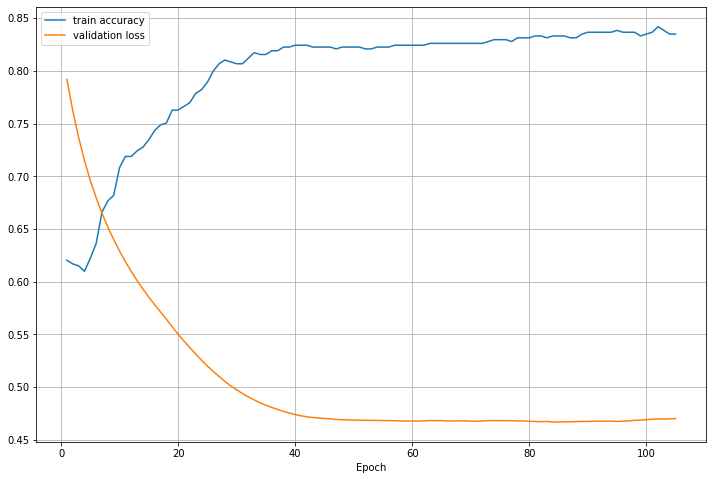

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.plot(xs, y_acc, ms=5, label='train accuracy')
plt.plot(xs, y_vloss, ms=5, label='validation loss')
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.show()

## 7. Epoch & Batch_size 값 다르게 해서 모델 정의/설정/학습/평가

In [28]:
del model

In [29]:
model = Sequential([
    Dense(30, input_dim=7, activation='relu'),
    Dense(12, activation='relu'),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [30]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
hist = model.fit(X_train, y_train, validation_split=0.2, verbose=0,
                 epochs=1000, batch_size=200,
                 callbacks=[checkpoint, early_stopping])


Epoch 00001: val_loss did not improve from 0.46691

Epoch 00002: val_loss did not improve from 0.46691

Epoch 00003: val_loss did not improve from 0.46691

Epoch 00004: val_loss did not improve from 0.46691

Epoch 00005: val_loss did not improve from 0.46691

Epoch 00006: val_loss did not improve from 0.46691

Epoch 00007: val_loss did not improve from 0.46691

Epoch 00008: val_loss did not improve from 0.46691

Epoch 00009: val_loss did not improve from 0.46691

Epoch 00010: val_loss did not improve from 0.46691

Epoch 00011: val_loss did not improve from 0.46691

Epoch 00012: val_loss did not improve from 0.46691

Epoch 00013: val_loss did not improve from 0.46691

Epoch 00014: val_loss did not improve from 0.46691

Epoch 00015: val_loss did not improve from 0.46691

Epoch 00016: val_loss did not improve from 0.46691

Epoch 00017: val_loss did not improve from 0.46691

Epoch 00018: val_loss did not improve from 0.46691

Epoch 00019: val_loss did not improve from 0.46691

Epoch 00020

In [31]:
from tensorflow.keras.models import load_model
best_model = load_model(model_path)
best_model.evaluate(X_test, y_test)

6/6 [==============================] - 0s 2ms/step - loss: 0.4132 - accuracy: 0.8436


[0.4131556749343872, 0.8435754179954529]

* 학습과정 시각화

In [32]:
y_acc = hist.history['accuracy']
y_vloss = hist.history['val_loss']
xs = np.arange(1, len(y_acc)+1)

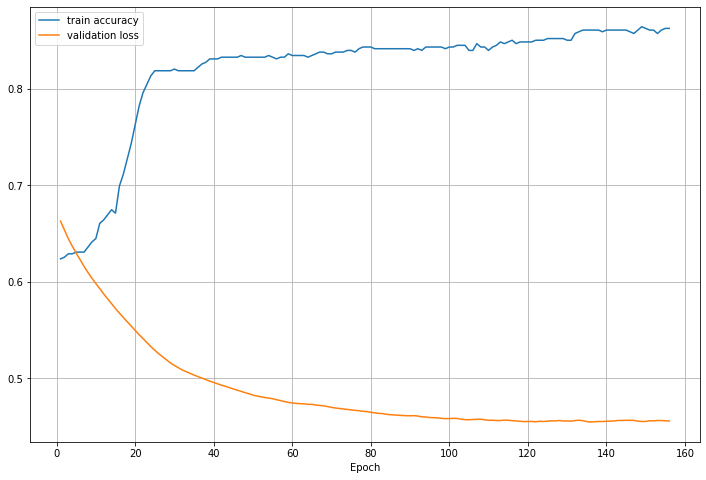

In [33]:
plt.figure(figsize=(12,8))
plt.plot(xs, y_acc, ms=5, label='train accuracy')
plt.plot(xs, y_vloss, ms=5, label='validation loss')
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.show()

8. 은닉층 개수 늘려서 (깔대기형)

In [37]:
del model

In [38]:
model2 = Sequential([
    Dense(64, input_dim=7, activation='relu'),
    Dense(32, activation='relu'),
    Dense(24, activation='relu'),
    Dense(12, activation='relu'),
    Dense(8, activation='relu'),
    Dense(4, activation='relu'),
    Dense(1, activation='sigmoid')
])
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 64)                512       
                                                                 
 dense_16 (Dense)            (None, 32)                2080      
                                                                 
 dense_17 (Dense)            (None, 24)                792       
                                                                 
 dense_18 (Dense)            (None, 12)                300       
                                                                 
 dense_19 (Dense)            (None, 8)                 104       
                                                                 
 dense_20 (Dense)            (None, 4)                 36        
                                                                 
 dense_21 (Dense)            (None, 1)                

In [39]:
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
hist2 = model2.fit(X_train, y_train, validation_split=0.2, verbose=0,
                 epochs=200, batch_size=200,
                 callbacks=[checkpoint, early_stopping])


Epoch 00001: val_loss did not improve from 0.45472

Epoch 00002: val_loss did not improve from 0.45472

Epoch 00003: val_loss did not improve from 0.45472

Epoch 00004: val_loss did not improve from 0.45472

Epoch 00005: val_loss did not improve from 0.45472

Epoch 00006: val_loss did not improve from 0.45472

Epoch 00007: val_loss did not improve from 0.45472

Epoch 00008: val_loss did not improve from 0.45472

Epoch 00009: val_loss did not improve from 0.45472

Epoch 00010: val_loss did not improve from 0.45472

Epoch 00011: val_loss did not improve from 0.45472

Epoch 00012: val_loss did not improve from 0.45472

Epoch 00013: val_loss did not improve from 0.45472

Epoch 00014: val_loss did not improve from 0.45472

Epoch 00015: val_loss did not improve from 0.45472

Epoch 00016: val_loss did not improve from 0.45472

Epoch 00017: val_loss did not improve from 0.45472

Epoch 00018: val_loss did not improve from 0.45472

Epoch 00019: val_loss did not improve from 0.45472

Epoch 00020

In [40]:
best_model = load_model(model_path)
best_model.evaluate(X_test, y_test)

6/6 [==============================] - 0s 2ms/step - loss: 0.4132 - accuracy: 0.8436


[0.4131556749343872, 0.8435754179954529]

* 학습 과정 시각화

In [41]:
y_acc = hist2.history['accuracy']
y_vloss = hist2.history['val_loss']
xs = np.arange(1, len(y_acc)+1)

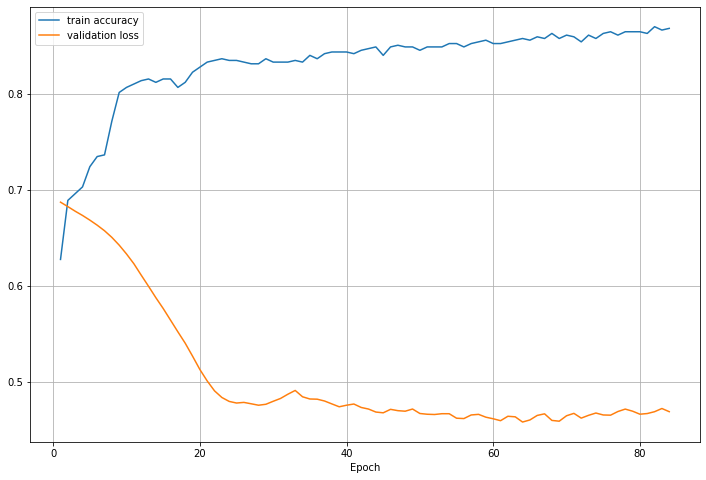

In [42]:
plt.figure(figsize=(12,8))
plt.plot(xs, y_acc, ms=5, label='train accuracy')
plt.plot(xs, y_vloss, ms=5, label='validation loss')
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.show()

## 9. 은닉층 개수 늘려서 (항아리형)

* 은닉층 6개 -> 4개 감소

In [130]:
del model3

In [273]:
del model3

In [274]:
model3 = Sequential([ 
    Dense(512, input_dim=7, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(4, activation='relu'),
    Dense(2, activation='relu'),
    Dense(1, activation='sigmoid')
])
model3.summary()

Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_470 (Dense)           (None, 512)               4096      
                                                                 
 dense_471 (Dense)           (None, 256)               131328    
                                                                 
 dense_472 (Dense)           (None, 128)               32896     
                                                                 
 dense_473 (Dense)           (None, 64)                8256      
                                                                 
 dense_474 (Dense)           (None, 32)                2080      
                                                                 
 dense_475 (Dense)           (None, 16)                528       
                                                                 
 dense_476 (Dense)           (None, 8)               

In [275]:
model_path3 = 'model/best_titanic3.h5'
# model_path = 'model/titanic_{epoch:03d}_{val_loss:.4f}.h5'

from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(
    model_path3, monitor = 'val_loss', save_best_only=True, verbose = 1
)

In [276]:
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
hist3 = model3.fit(X_train, y_train, validation_split=0.2, verbose=0,
                 epochs=400, batch_size=200,
                 callbacks=[checkpoint, early_stopping])


Epoch 00001: val_loss improved from inf to 0.63342, saving model to model/best_titanic3.h5

Epoch 00002: val_loss improved from 0.63342 to 0.58635, saving model to model/best_titanic3.h5

Epoch 00003: val_loss improved from 0.58635 to 0.57710, saving model to model/best_titanic3.h5

Epoch 00004: val_loss did not improve from 0.57710

Epoch 00005: val_loss improved from 0.57710 to 0.56517, saving model to model/best_titanic3.h5

Epoch 00006: val_loss improved from 0.56517 to 0.55811, saving model to model/best_titanic3.h5

Epoch 00007: val_loss did not improve from 0.55811

Epoch 00008: val_loss improved from 0.55811 to 0.55751, saving model to model/best_titanic3.h5

Epoch 00009: val_loss did not improve from 0.55751

Epoch 00010: val_loss did not improve from 0.55751

Epoch 00011: val_loss did not improve from 0.55751

Epoch 00012: val_loss improved from 0.55751 to 0.55684, saving model to model/best_titanic3.h5

Epoch 00013: val_loss improved from 0.55684 to 0.55615, saving model to

In [277]:
best_model = load_model(model_path3)
best_model.evaluate(X_test, y_test)

6/6 [==============================] - 0s 3ms/step - loss: 0.5612 - accuracy: 0.8547


[0.5611864924430847, 0.8547486066818237]

## 결론
* Dense의 숫자, Dense의 깊이보다 중요한 점은 